# Stochastic Nested Variance Reduction Gradient (SNVRG) and Stochastically Controlled Stochastic Gradient (SCSG) for Non-convex Optimization

__Authors: Cheng ZHANG & Shiwen XIA__

__Supervisor: Marco CUTURI__

This notebook implements 
- the SNVRG algorithm proposed in this [paper](https://papers.nips.cc/paper/7648-stochastic-nested-variance-reduced-gradient-descent-for-nonconvex-optimization.pdf) by Dongruo Zhou et al.
- the SCSG algprithm proposed in this [paper](https://arxiv.org/pdf/1706.09156.pdf) by Lihua Lei et al.

We apply the SNVRG and SCSG algorithm to a convex problem (Logistic regression with LASSO regularization) and a non-convex problem (MNIST image classification). We compare their performance with SVRG on the convex problem and with Adam and SVRG on the non-convex problem.

## Prerequisite (optional)

If you would like to navigate the table of contents in the notebook in order to facilitate the reading, you need to first install [__jupyter_contrib_nbextensions__](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html). 

Please go to the following GitHub repositories 
- https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator and follow the instructions to install __jupyter_nbextensions_configurator__. You can simply execute this command line ```conda install -c conda-forge jupyter_nbextensions_configurator```
- https://github.com/ipython-contrib/jupyter_contrib_nbextensions and follow the instructions to install __jupyter_contrib_extensions__. You can simply execute these command lines `conda install -c conda-forge jupyter_contrib_nbextensions` and `jupyter contrib nbextension install --user`.

After these two installations, restart your jupyter notebook and you will see a new tag named __Nbextensions__. Click it and enable __Table of Contents (2)__. Open the notebook that you want to execute, click the icon __Table of Contents__ and you will see the table of contents appearing on the left side of the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Toy Convex Problem: Logistic Regression with LASSO regularization

We first compare SVRG, SNVRG and SCSG on a toy convex problem.

### Genrate data

We generate $n$ points $X$ of dimension $p$, the parameter $w$ of dimension $p$ and the corresponding labels $y = \mathrm{sgn}(Xw + \epsilon)$ where $\epsilon \sim N(0, 1)$ which forms a binary classification problem.

Here we take $n = 1000$ and $p = 5$.

In [2]:
# Generate the data
n, p = 1000, 5

X = np.random.randn(n, p)
w = np.random.randn(p)

sigma = 1
xi = np.random.randn(n)

y = np.sign(X.dot(w) + sigma*xi)

### Loss function and gradients

We define the logistic loss $L_{logistic}(\theta) = \frac{1}{n}\sum_{i=1}^n \log(1 + e^{-y_i X_i^\top \theta})$ with the LASSO regularization $L(\theta) = L_{logistic}(\theta) + \lambda |\theta|_1$ as the total loss. Our goal is to minimize this loss function.

This is a convex optimization problem, however its explicite solution is difficult to obtain. Thus we use gradient descent to obtain its minimum. It is easy to derive its gradient $$\nabla_\theta L(\theta) = \frac{1}{n}\sum_{i=1}^n \frac{-y_i X_i}{1 + e^{y_i X_i^\top \theta}} + \mathrm{sgn}(\theta)$$

We also define the gradient function for a single point as we use single point gradient in the inner loop of SVRG algorithm. $$\nabla_\theta L_i(\theta) = \frac{-y_i X_i}{1 + e^{y_i X_i^\top \theta}} + \mathrm{sgn}(\theta)$$

In [3]:
# Define the loss function
def LASSO_loss(X, y, theta, lamda):
    '''Return the logistic LASSO loss for parameters `theta`.'''
    return np.mean(np.log(1.0 + np.exp(- y * X.dot(theta)))) + lamda * np.sum(np.abs(theta))

# Define the gradient of the loss function
def full_grad_loss(X, y, theta, lamda):
    '''Return the gardient of the logistic LASSO loss at point `theta`.'''
    n = X.shape[0]
    LASSO_grad = lamda * ((theta >= 0).astype(np.int) * 2 - 1)
    return (1./n) * (- y/(1.0 + np.exp(y * X.dot(theta)))).dot(X) + LASSO_grad

def grad(X, y, theta, lamda, i):
    '''Return the gardient of the logistic LASSO loss at point `theta` for datum i.'''
    n = X.shape[0]
    LASSO_grad = lamda * ((theta >= 0).astype(np.int) * 2 - 1)
    return (1./n) * (- y[i]/(1.0 + np.exp(y[i] * X[i].dot(theta)))) * X[i] + LASSO_grad

### SVRG (Stochastic Variance Reduced Gradient) algorithm

The SVRG algorithm performs as follows 
- Initialize the parameter $\theta_0$
- for $t = 1, 2, \ldots, T$
    - compute the full gradient $g_{full} = \nabla_\theta L(\theta_{t-1})$
    - $\theta_{t}^{(0)} = \theta_{t-1}$
    - for $k = 1, 2, \ldots, M$
        - randomly choose $i$ in $\{1, \ldots, n\}$
        - compute $g = \nabla_\theta L_i(\theta_{t}^{(k-1)}) - \nabla_\theta L_i(\theta_{t-1}) + g_{full}$
        - update $\theta_t^{(k)} = \theta_t^{(k-1)} - \alpha g$
    - take $\theta_t = \frac{1}{M}\sum_{k=1}^M \theta_t^{(k)}$ or $\theta_t = \theta_t^{(M)}$
    
where $\alpha$ is the learning rate.

The intuition behind SVRG is to calculate the full gradient every $M$ steps of gradient descent in order to reduce the variance. However, when the amount of data becomes larger, even one calculation of full gradient is too costful. 

In our implementation, we take the mean of parameters after the calculations of the inner loop in order to get a more stable parameter.

In [4]:
# Define the SVRG algorithm
def SVRG(X, y, theta, lamda, max_iter, max_iter_inner, step_size):
    n, p = X.shape
    theta_hat_history = []
    loss_history = []
    theta_history = np.zeros((max_iter_inner, p))
    
    theta_hat = theta
    
    for t in range(max_iter):
        full_gradient = full_grad_loss(X, y, theta_hat, lamda)
        for k in range(max_iter_inner):
            i = np.random.randint(0, n)
            theta = theta - step_size * (grad(X, y, theta, lamda, i) - grad(X, y, theta_hat, lamda, i) + full_gradient)
            theta_history[k] = theta
            
        theta_hat = np.mean(theta_history, axis=0)
        
        theta_hat_history.append(theta_hat)
        loss_history.append(LASSO_loss(X, y, theta_hat, lamda))
    
    return theta_hat, theta_hat_history, loss_history

In [5]:
theta = np.random.randn(p)
svrg_theta_hat, svrg_theta_hat_history, svrg_loss_history = SVRG(X, y, theta, lamda=0.1, max_iter=100, max_iter_inner=100, step_size=0.05)

In [6]:
# Define the approximative minimum value of the loss function
svrg_min_loss = np.min(svrg_loss_history)

### SNVRG (Stochastic Nested Variance Reduced Gradient) algorithm

This is an improved version of SVRG algorithm. It considers the SVRG algorithm as it utilizes two reference points to construct a semi-stochastic gradient with diminishing variance in each iteration. Instead of using two reference points, SNVRG utilizes $K+1$ nested reference points to further reduce the variance.

Consider we use $K+1$ reference points, loop parameters $T_l, l \in \{1, \ldots, K\}$, batch parameters $B_l, l \in \{1, \ldots, K\}$ and the base batch size $B$. The SNVRG algorithm performs as follows 
- Initialize the parameter $\theta_0$
- for $t = 1, 2, \ldots, T$
    - $\theta_{t, 0}^{(l)} = \theta_{t-1},~ g_{t, 0}^{(l)} = 0,~ 0 \leq l \leq K$
    - uniformly choose a batch with size $B$ and compute the gradient on that batch as $g_{t, 0}^{(0)}$
    - $\theta_{t, 1} = \theta_{t-1} - \alpha \sum_{l=0}^K g_{t, 0}^{(l)}$
    - for $m = 1, 2, \ldots, \prod_{l=1}^K T_l - 1$
        - find index $r = \min \{j: 0 = (m ~\mathrm{mod}~ \prod_{l=j+1}^K T_l), ~0\leq j \leq K\}$
        - update reference points $\theta_{t, m}^{(l)} = \theta_{t, m-1}^{(l)}, ~0 \leq l \leq r - 1 \quad \mathrm{and} \quad \theta_{t, m}^{(l)} = \theta_{t, m}, ~r \leq l \leq K$
        - update reference gradients, for $0 \leq l \leq r-1, ~g_{t, m}^{(l)} = g_{t, m-1}^{(l)}$ and for $l = r, \ldots, K$
            - uniformly choose a batch with size $B_l$
            - compute the reference gradient $g_{t, m}^{(l)} = g(\theta_{t, m}^{(l)}) - g(\theta_{t, m}^{(l-1)})$ on the chosen batch
        - $\theta_{t, m+1} = \theta_{t, m} - \alpha \sum_{l=0}^K g_{t, m}^{(l)}$
    - $\theta_t = \theta_{t, \prod_{l=1}^K T_l}$

$\alpha$ is the learning rate.

In [7]:
# Define the function to find the mod index
def find_index(t, loop_params):
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0

def update_reference_points(theta_reference, theta, r):
    updated_reference = theta_reference.copy()
    K, p = theta_reference.shape
    to_update = np.broadcast_to(theta, shape=(K - r, p))
    updated_reference[r:] = to_update
    
    return updated_reference

def update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size):
    n = X.shape[0]
    K, p = theta_reference.shape
    for l in range(r, K):
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda)
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda) \
                            - full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l-1], lamda)
                
    return gradients

In [8]:
# Define one epoch SNVRG
def one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size):
    assert len(loop_params) == len(batch_params), "The number of loop parameters should be the same as that of batch parameters!"
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n, p = X.shape
    theta_reference = np.broadcast_to(theta, shape=(K+1, p))
    theta_history = []
    
    gradients = np.zeros((K+1, p))
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    base_batch = indexes[0:base_batch_size]
    gradients[0] = full_grad_loss(X[base_batch], y[base_batch], theta, lamda)
    grad = np.sum(gradients, axis=0)
    theta = theta - 0.1 / step_size * grad
    theta_history.append(theta)
    
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        theta_reference = update_reference_points(theta_reference, theta, r)
        gradients = update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size)
        grad = np.sum(gradients, axis=0)
        theta = theta - 0.1 / step_size * grad
        
        theta_history.append(theta)
        
    final_theta = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    final_loss = LASSO_loss(X, y, final_theta, lamda)
    
    return final_theta, theta_history[-1], final_loss

In [9]:
# The SNVRG algorithm, with several one_epoch_SNVRG iterations
def SNVRG(X, y, theta, lamda, max_iter, loop_params, batch_params, base_batch_size, step_size):
    theta_history = []
    loss_history = []
    for t in range(max_iter):
        theta_hat, theta, loss = one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size)
        theta_history.append(theta_hat)
        loss_history.append(loss)
    
    theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    return theta_hat, theta_history, loss_history

In [10]:
# We use the same parameter as in SVRG in order to compare the results later
theta = np.random.randn(p)
loop_params = [100]
base_batch_size = 1000
batch_params = [1]
step_size = 2.0
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(X, y, theta, 0.1, 100, loop_params, batch_params, base_batch_size, step_size)

### SCSG (Stochastically Controlled Stochastic Gradient) algorithm

The SCSG algorithm is also a variant version of SVRG. Instead of computing full gradient on the full dataset at each outer iteration in SVRG, it uniformly chooses a batch to compute gradients. And for the inner iterations, instead of computing a single gradient at each step, it randomly chooses a mini-batch to compute gradients. And the number of inner iterations is not fixed but randomly generated according to a geometric distribution.

We consider the number of outer iterations $T$, learning rates $(\alpha_t)_{t=1}^T$, batch sizes $(B_t)_{t=1}^T$ and the mini-batch sizes $(b_t)_{t=1}^T$. The SCSG algorithm perform as follows 
- Initialize the parameter $\theta_0$
- for $t = 1, 2, \ldots, T$
    - uniformly sample a batch with size $B_t$ and compute the gradients on that batch $g_t$
    - $\theta_t^{(0)} = \theta_{t-1}$
    - generate $N_t \sim \mathrm{Geom}(B_t / (B_t + b_t))$
    - for $k = 1, 2, \ldots, N_t$
        - uniformly sample a mini-batch with size $b_t$
        - compute the gradient $g = g(\theta_t^{(k-1)}) - g(\theta_{t-1}) + g_t$ on that mini-batch
        - update the parameter $\theta_t^{(k)} = \theta_t^{(k-1)} - \alpha g$
    - take $\theta_t = \theta_t^{(N_t)}$
    
$\alpha$ is the learning rate.

In [11]:
def SCSG(X, y, theta, lamda, max_iter, batch_params, mini_batch_params, step_size):
    theta_history = []
    loss_history = []
    if isinstance(batch_params, int):
        batch_params = [batch_params] * max_iter
    assert len(batch_params) == max_iter, 'Length of batch parameters ({}) should be the same as max iterations ({})'.format(len(batch_params), max_iter)
    
    if isinstance(mini_batch_params, int):
        mini_batch_params = [mini_batch_params] * max_iter
    assert len(mini_batch_params) == max_iter, 'Length of mini-batch parameters ({}) should be the same as max iterations ({})'.format(len(mini_batch_params), max_iter)
    
    indices = np.arange(X.shape[0])
    for t in range(max_iter):
        np.random.shuffle(indices)
        X_batch, y_batch = X[indices[:batch_params[t]]], y[indices[:batch_params[t]]]
        theta_hat = theta
        full_gradient = full_grad_loss(X_batch, y_batch, theta_hat, lamda)
        N = np.random.geometric(1.0 * mini_batch_params[t] / (batch_params[t] + mini_batch_params[t]))
        for k in range(N):
            i = k % (batch_params[t] // mini_batch_params[t])
            X_mini_batch, y_mini_batch = X[indices[i*mini_batch_params[t]:(i+1)*mini_batch_params[t]]], y[indices[i*mini_batch_params[t]:(i+1)*mini_batch_params[t]]]
            gradient = full_grad_loss(X_mini_batch, y_mini_batch, theta, lamda) - full_grad_loss(X_mini_batch, y_mini_batch, theta_hat, lamda) + full_gradient
            theta = theta - step_size * gradient
            
        theta_history.append(theta)
        loss_history.append(LASSO_loss(X, y, theta, lamda))
        
    return theta, theta_history, loss_history

In [12]:
# We still use the same parameter as in SVRG in order to compare the results later
theta = np.random.randn(p)
max_iter = 100
batch_params = 1000
mini_batch_params = 16
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 0.5 / L / (batch_params / mini_batch_params)
scsg_theta_hat, scsg_theta_hat_history, scsg_loss_history = SCSG(X, y, theta, 0.1, max_iter, batch_params, mini_batch_params, step_size)

### Performance comparison

We now compare the performance of the three stochastic optimization algorithms. We first take the same hyper-parameter settings to see if the three algorithms produce the same results.

In [13]:
# take the minimum loss of the three algorithms as the minimum
snvrg_min_loss = np.min(snvrg_loss_history)
min_loss = np.min([svrg_min_loss, snvrg_min_loss])
scsg_min_loss = np.min(scsg_loss_history)
min_loss = np.min([min_loss, scsg_min_loss])

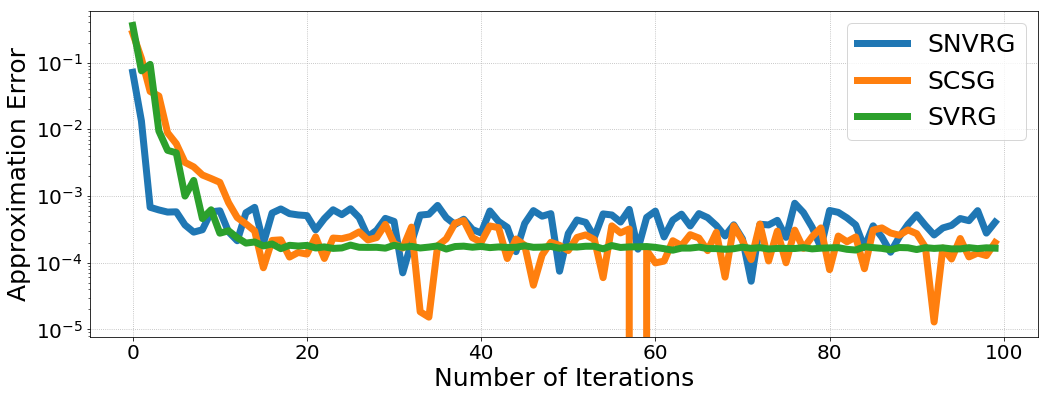

In [14]:
# Let us now plot the convergence in terms of values of loss
plt.figure(figsize=(17, 6))
plt.semilogy(snvrg_loss_history - min_loss, label='SNVRG', lw=7)
plt.semilogy(scsg_loss_history - min_loss, label='SCSG', lw=7)
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

We can see that the convergences of the three algorithms are quite similar by taking the same hyper-parameter settings. Notice that SNVRG and SCSG are more oscillating than SVRG which is because we take the mean of parameters at each iteration in SVRG.

Now we test the performance of SNVRG and SCSG by changing hyper-parameter setting. 

For SNVRG, we take $K = 2$ as in the paper. And we choose the loop parameters $T_l = \{2, 2\}$, the batch parameters $B_l = \{128, 64\}$, the base batch size $B = 256$ and the step size parameter $M = 6L$ where $L$ is the Lipschitz constant, as suggested in the paper.

For SCSG, we take the fixed batch size $B = 256$ and fixed mini-batch size $b = 16$. The learning rate is set as $\frac{1}{2L(B/b)^{2/3}}$ as suggested in the paper.

In [15]:
theta = np.random.randn(p)
loop_params = [2, 2]
base_batch_size = 256
batch_params = [128, 64]
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 6 * L
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(X, y, theta, 0.1, 100, loop_params, batch_params, base_batch_size, step_size)

In [16]:
theta = np.random.randn(p)
max_iter = 100
batch_params = 256
mini_batch_params = 16
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 0.5 / L / (batch_params / mini_batch_params)**(2./3)
scsg_theta_hat, scsg_theta_hat_history, scsg_loss_history = SCSG(X, y, theta, 0.1, max_iter, batch_params, mini_batch_params, step_size)

In [17]:
snvrg_min_loss = np.min(snvrg_loss_history)
scsg_min_loss = np.min(scsg_loss_history)

In [18]:
min_loss = np.min([svrg_min_loss, snvrg_min_loss, scsg_min_loss])

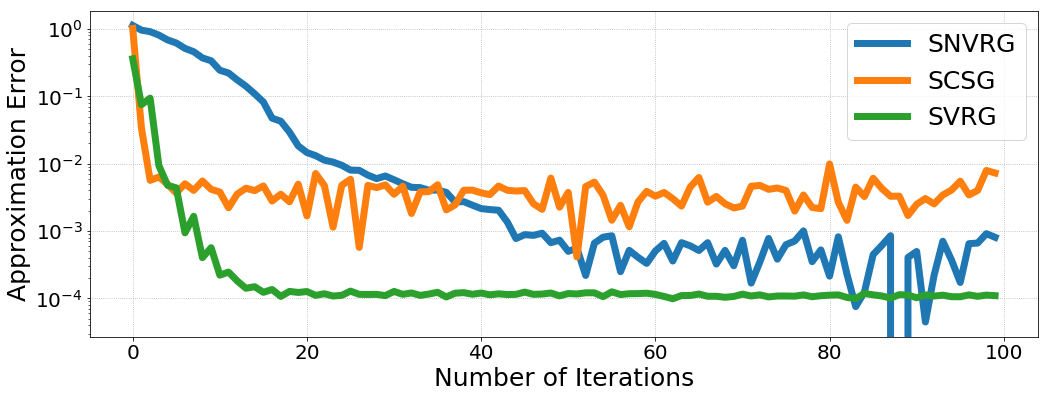

In [19]:
# Let us now plot the convergence in terms of values of loss
plt.figure(figsize=(17, 6))
plt.semilogy(snvrg_loss_history - min_loss, label='SNVRG', lw=7)
plt.semilogy(scsg_loss_history - min_loss, label='SCSG', lw=7)
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

We can see that the SVRG converges faster and attains the best performance. This is because we change the hyper-parameter settings for the other two, which leads to less inner iterations in SNVRG and SCSG. And the base batch size for the outer loop is also smaller than that in SVRG which takes the full dataset. 

However, as we previously mentioned, when the dataset becomes larger, it is impossible to compute the full gradients in SVRG. 

## Non-convex Problem: MNIST dataset image classification
As presented in the paper, we take the image classification non-convex problem on MNIST dataset to see the performance of SNVRG and SCSG, and we compare them with Adam and a batch version of SVRG.

In order to perform the automatic differentiation, we use TensorFlow framework. Thus we reimplement the three algorithms in TensorFlow here.

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

### LeNet architecture

We apply the classic [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) architecture for MNIST image classification task.

In [21]:
# Image size in MNIST dataset is (28, 28), so the first convolutional layer is applied with SAME padding, to fit with the LeNet architecture
def CNN_LeNet(images):
    net = tf.reshape(images, shape=[-1, 28, 28, 1])
    net = Conv2D(filters=6, kernel_size=5, strides=(1, 1), activation='relu', padding='SAME')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Conv2D(filters=16, kernel_size=5, strides=(1, 1), activation='relu', padding='VALID')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Flatten()(net)
    net = Dense(120, activation='relu')(net)
    net = Dense(84, activation='relu')(net)
    net = Dense(10, activation=None)(net)
    
    return net

### Loss function

As a multi-classification problem, we use the categorical cross entropy as loss function.

In [22]:
def loss(y, pred):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
    return cross_entropy

### SVRG, SNVRG, SCSG optimizer implementation

We define the three optimizers by inheriting the tensorflow Optimizer class.

In [23]:
class SVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, learning_rate=1e-3):
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._variance_reduction_ph = [tf.placeholder(tf.float32, shape=v.get_shape()) 
                                           for _, v in self._grads_and_vars]
        self._bias_correction_ph = [tf.placeholder(tf.float32, shape=v.get_shape())
                                           for _, v in self._grads_and_vars]
    
        self._update = self._compute_single_update()
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
    
    def _compute_single_update(self):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (g, v) in enumerate(grads_and_vars):
            g += self._bias_correction_ph[i] - self._variance_reduction_ph[i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, inner_iter, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        feed_dict_single = []
        gs, _ = zip(*self._grads_and_vars)
        bias_correction = sess.run(gs, feed_dict=feed_dict)
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        for i in range(inner_iter):
            sample = np.random.randint(batch_size)
            feed_dict_single.append({input_ph[j]: input_data[j][sample:sample+1] for j in range(len(input_data))})
            
        for i in range(inner_iter):
            single_grads_and_vars = sess.run(gs, feed_dict=feed_dict_single[i])
            
            _feed_dict = feed_dict_single[i]
            _feed_dict.update(dict(zip(self._bias_correction_ph, bias_correction)))
            _feed_dict.update(dict(zip(self._variance_reduction_ph, single_grads_and_vars)))
            
            _ = sess.run(self._update, feed_dict=_feed_dict)

In [24]:
class SNVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, K, learning_rate=1e-3):
        self.K = K
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._reference_gradient_ph = [[tf.placeholder(tf.float32, shape=v.get_shape()) for _, v in self._grads_and_vars]
                                       for _ in range(self.K+1)]
        
        self._update = self._compute_single_update
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
            
    def _compute_single_update(self, l):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (_, v) in enumerate(grads_and_vars):
            g = self._reference_gradient_ph[l][i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, feed_dict_total, n, batch_size, loop_params, mini_batch_params, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        input_total_ph = list(feed_dict_total.keys())
        input_total_data = list(feed_dict_total.values())
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        gs, vs = zip(*self._grads_and_vars)
        shift_gradients = []
        for l in range(K+1):
            gss = []
            for g in gs:
                gss.append(tf.identity(g))
                
            shift_gradients.append(gss)
        
        reference_gradients = [[np.zeros(v.get_shape().as_list()) for v in vs] for _ in range(self.K+1)]
        reference_gradients[0] = sess.run(gs, feed_dict=feed_dict)
        
        feed_dict.update(dict(zip(self._reference_gradient_ph[0], reference_gradients[0])))
        _ = sess.run(self._update(0), feed_dict=feed_dict)

        for t in range(1, np.prod(loop_params)):      
            gs, vs = zip(*self._grads_and_vars)
            
            r = find_index(t, loop_params)
            
            for l in range(r, K+1):
                samples = np.random.choice(n, size = mini_batch_params[l-1], replace=False)
                feed_dict_single = {input_total_ph[j]: input_total_data[j][samples] for j in range(len(input_total_data))}
                
                gss = []
                for g in gs:
                    gss.append(tf.identity(g))
                shift_gradients[l] = gss
                
                for i, g in enumerate(shift_gradients[l]):
                    reference_gradients[l][i] = sess.run(g - shift_gradients[l-1][i], feed_dict=feed_dict_single)
                
            for l in range(K+1):
                feed_dict_single.update(dict(zip(self._reference_gradient_ph[l], reference_gradients[l])))
                _ = sess.run(self._update(l), feed_dict=feed_dict_single)

In [25]:
class SCSGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, learning_rate=1e-3):
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._variance_reduction_ph = [tf.placeholder(tf.float32, shape=v.get_shape()) 
                                           for _, v in self._grads_and_vars]
        self._bias_correction_ph = [tf.placeholder(tf.float32, shape=v.get_shape())
                                           for _, v in self._grads_and_vars]
        
        self._update = self._compute_single_update()
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
    
    def _compute_single_update(self):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (g, v) in enumerate(grads_and_vars):
            g += self._bias_correction_ph[i] - self._variance_reduction_ph[i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, mini_batch_size, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        feed_dict_single = []
        gs, _ = zip(*self._grads_and_vars)
        bias_correction = sess.run(gs, feed_dict=feed_dict)
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        for i in range(batch_size // mini_batch_size):
            feed_dict_single.append({input_ph[j]: input_data[j][i*mini_batch_size:(i+1)*mini_batch_size] 
                                             for j in range(len(input_data))})
            
        for i in range(batch_size // mini_batch_size):
            single_grads_and_vars = sess.run(gs, feed_dict=feed_dict_single[i])
            
            _feed_dict = feed_dict_single[i]
            _feed_dict.update(dict(zip(self._bias_correction_ph, bias_correction)))
            _feed_dict.update(dict(zip(self._variance_reduction_ph, single_grads_and_vars)))
            
            _ = sess.run(self._update, feed_dict=_feed_dict)

In [26]:
# Evaluate the performance by error rate on the test set
def evaluate(y, y_pred):
    preds = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y, axis=1)
    err = 1. - tf.reduce_mean(tf.cast(tf.equal(y_true, preds), tf.float32))
    return err

### Results

We compare the results of Adam, batch version SVRG, SNVRG and SCSG in this section. In each epoch, we just take a batch of training set to feed to different algorithms, thus it corresponds to a batch version of SVRG.

We plot the batch loss and test error w.r.t. the number of calculated gradients (which seems reasonable to us) in order to compare the performance.

In [27]:
# load MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### Adam Optimizer

In [28]:
tf.reset_default_graph()

lr = 0.01
epochs = 200
batch_size = 512

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.AdamOptimizer(learning_rate=lr)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    adam_loss_history = []
    adam_test_error_history = []
    adam_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
        nb_grads += batch_size
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        adam_loss_history.append(c)
        adam_test_error_history.append(err)
        adam_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/200
	Loss: 2.3086860179901123 	Test Error: 0.6840000152587891
Epoch 2/200
	Loss: 2.2011702060699463 	Test Error: 0.675000011920929
Epoch 3/200
	Loss: 1.95455801486969 	Test Error: 0.4171000123023987
Epoch 4/200
	Loss: 1.4758120775222778 	Test Error: 0.3687000274658203
Epoch 5/200
	Loss: 1.1471766233444214 	Test Error: 0.3098999857902527
Epoch 6/200
	Loss: 1.1017595529556274 	Test Error: 0.3515999913215637
Epoch 7/200
	Loss: 1.0964289903640747 	Test Error: 0.24309998750686646
Epoch 8/200
	Loss: 0.7597075700759888 	Test Error: 0.22939997911453247
Epoch 9/200
	Loss: 0.8238134384155273 	Test Error: 0.23589998483657837
Epoch 10/200
	Loss: 0.722975492477417 	Test Error: 0.21050000190734863
Epoch 11/200
	Loss: 0.7362105846405029 	Test Error: 0.16519999504089355
Epoch 12/200
	Loss: 0.6522687673568726 	Test Error: 0.11970001459121704
Epoch 13/200
	Loss: 0.48931610584259033 	Test Error: 0.11269998550415039
Epoch 14/200
	Loss: 0.4827193021774292 	Test Error: 0.11559998989105225
Epoch 15/2

	Loss: 0.08491984009742737 	Test Error: 0.01819998025894165
Epoch 117/200
	Loss: 0.05847109481692314 	Test Error: 0.018899977207183838
Epoch 118/200
	Loss: 0.0458344891667366 	Test Error: 0.021099984645843506
Epoch 119/200
	Loss: 0.06586533784866333 	Test Error: 0.021300017833709717
Epoch 120/200
	Loss: 0.058799147605895996 	Test Error: 0.018800020217895508
Epoch 121/200
	Loss: 0.062049705535173416 	Test Error: 0.01819998025894165
Epoch 122/200
	Loss: 0.037235990166664124 	Test Error: 0.018700003623962402
Epoch 123/200
	Loss: 0.06859537214040756 	Test Error: 0.018999993801116943
Epoch 124/200
	Loss: 0.045962341129779816 	Test Error: 0.018800020217895508
Epoch 125/200
	Loss: 0.08928912878036499 	Test Error: 0.019999980926513672
Epoch 126/200
	Loss: 0.10594416409730911 	Test Error: 0.019599974155426025
Epoch 127/200
	Loss: 0.04560321941971779 	Test Error: 0.02069997787475586
Epoch 128/200
	Loss: 0.07016761600971222 	Test Error: 0.023500025272369385
Epoch 129/200
	Loss: 0.0425622723996639

#### SVRG Optimizer (batch version)

In [29]:
tf.reset_default_graph()

max_iter_inner = 64
lr = 0.001
epochs = 400
batch_size = 512

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SVRGOptimizer(cost, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    svrg_loss_history = []
    svrg_test_error_history = []
    svrg_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        # learning rate decay every 50 epochs
        if epoch % 50 == 0 and epoch != 0:
            lr *= 0.9
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        optimizer.batch_update(sess, feed_dict, batch_size, max_iter_inner, lr)
        nb_grads += batch_size + max_iter_inner
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        svrg_loss_history.append(c)
        svrg_test_error_history.append(err)
        svrg_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/400
	Loss: 2.309011697769165 	Test Error: 0.8889999985694885
Epoch 2/400
	Loss: 2.3008790016174316 	Test Error: 0.8888999819755554
Epoch 3/400
	Loss: 2.299562931060791 	Test Error: 0.8883000016212463
Epoch 4/400
	Loss: 2.299243211746216 	Test Error: 0.8848000168800354
Epoch 5/400
	Loss: 2.293478012084961 	Test Error: 0.8819000124931335
Epoch 6/400
	Loss: 2.289616107940674 	Test Error: 0.8734999895095825
Epoch 7/400
	Loss: 2.285104990005493 	Test Error: 0.8716000318527222
Epoch 8/400
	Loss: 2.2819724082946777 	Test Error: 0.8695999979972839
Epoch 9/400
	Loss: 2.278137445449829 	Test Error: 0.8640999794006348
Epoch 10/400
	Loss: 2.2701849937438965 	Test Error: 0.8690000176429749
Epoch 11/400
	Loss: 2.2612996101379395 	Test Error: 0.8677999973297119
Epoch 12/400
	Loss: 2.25253963470459 	Test Error: 0.8669999837875366
Epoch 13/400
	Loss: 2.2523133754730225 	Test Error: 0.8594000339508057
Epoch 14/400
	Loss: 2.249201536178589 	Test Error: 0.8564000129699707
Epoch 15/400
	Loss: 2.246

	Loss: 0.5192338228225708 	Test Error: 0.15390002727508545
Epoch 117/400
	Loss: 0.45477306842803955 	Test Error: 0.12999999523162842
Epoch 118/400
	Loss: 0.3711168169975281 	Test Error: 0.10829997062683105
Epoch 119/400
	Loss: 0.369785338640213 	Test Error: 0.09570002555847168
Epoch 120/400
	Loss: 0.31988009810447693 	Test Error: 0.07849997282028198
Epoch 121/400
	Loss: 0.27548137307167053 	Test Error: 0.07910001277923584
Epoch 122/400
	Loss: 0.2558515667915344 	Test Error: 0.07840001583099365
Epoch 123/400
	Loss: 0.3300788998603821 	Test Error: 0.07569998502731323
Epoch 124/400
	Loss: 0.2998991310596466 	Test Error: 0.07920002937316895
Epoch 125/400
	Loss: 0.2728371024131775 	Test Error: 0.07510000467300415
Epoch 126/400
	Loss: 0.2083715945482254 	Test Error: 0.07649999856948853
Epoch 127/400
	Loss: 0.273561954498291 	Test Error: 0.07899999618530273
Epoch 128/400
	Loss: 0.26502910256385803 	Test Error: 0.08050000667572021
Epoch 129/400
	Loss: 0.2632119953632355 	Test Error: 0.07499998

	Loss: 0.17346017062664032 	Test Error: 0.052799999713897705
Epoch 229/400
	Loss: 0.16029734909534454 	Test Error: 0.05330002307891846
Epoch 230/400
	Loss: 0.1319376528263092 	Test Error: 0.050999999046325684
Epoch 231/400
	Loss: 0.14194761216640472 	Test Error: 0.0526999831199646
Epoch 232/400
	Loss: 0.18399381637573242 	Test Error: 0.054000020027160645
Epoch 233/400
	Loss: 0.17279943823814392 	Test Error: 0.05119997262954712
Epoch 234/400
	Loss: 0.1733771562576294 	Test Error: 0.053600013256073
Epoch 235/400
	Loss: 0.16180329024791718 	Test Error: 0.05470001697540283
Epoch 236/400
	Loss: 0.1789822280406952 	Test Error: 0.050999999046325684
Epoch 237/400
	Loss: 0.18158717453479767 	Test Error: 0.0526999831199646
Epoch 238/400
	Loss: 0.1693350374698639 	Test Error: 0.0494999885559082
Epoch 239/400
	Loss: 0.12579937279224396 	Test Error: 0.05169999599456787
Epoch 240/400
	Loss: 0.14831551909446716 	Test Error: 0.051599979400634766
Epoch 241/400
	Loss: 0.17319022119045258 	Test Error: 0.

	Loss: 0.15475791692733765 	Test Error: 0.038600027561187744
Epoch 340/400
	Loss: 0.09866733103990555 	Test Error: 0.038900017738342285
Epoch 341/400
	Loss: 0.08805301040410995 	Test Error: 0.03949999809265137
Epoch 342/400
	Loss: 0.09851016104221344 	Test Error: 0.03850001096725464
Epoch 343/400
	Loss: 0.1427290290594101 	Test Error: 0.042900025844573975
Epoch 344/400
	Loss: 0.10426880419254303 	Test Error: 0.038999974727630615
Epoch 345/400
	Loss: 0.10038893669843674 	Test Error: 0.03780001401901245
Epoch 346/400
	Loss: 0.14742203056812286 	Test Error: 0.04110002517700195
Epoch 347/400
	Loss: 0.09145832061767578 	Test Error: 0.03799998760223389
Epoch 348/400
	Loss: 0.10722725093364716 	Test Error: 0.038900017738342285
Epoch 349/400
	Loss: 0.11290900409221649 	Test Error: 0.04280000925064087
Epoch 350/400
	Loss: 0.14653605222702026 	Test Error: 0.03979998826980591
Epoch 351/400
	Loss: 0.08471175283193588 	Test Error: 0.036499977111816406
Epoch 352/400
	Loss: 0.12221536040306091 	Test 

#### SNVRG Optimizer

In [ ]:
tf.reset_default_graph()

n = 55000

epochs = 100
batch_size = 256
loop_params = [4, 4]
batch_params = [8, 1]
lr = 0.01
K = len(loop_params)

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SNVRGOptimizer(cost, K, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    snvrg_loss_history = []
    snvrg_test_error_history = []
    snvrg_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        # learning rate decay every 30 epochs
        if epoch % 30 == 0 and epoch != 0:
            lr *= 0.9
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        feed_dict_total = {X: mnist.train.images, y: mnist.train.labels}
        optimizer.batch_update(sess, feed_dict, feed_dict_total, n, batch_size, loop_params, batch_params, lr)
        nb_grads += batch_size
        
        for i, _ in enumerate(loop_params):
            nb_grads += batch_params[i] * np.prod(loop_params[:i+1])
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        snvrg_loss_history.append(c)
        snvrg_test_error_history.append(err)
        snvrg_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/400
	Loss: 2.295488119125366 	Test Error: 0.8666000366210938
Epoch 2/400
	Loss: 2.2840466499328613 	Test Error: 0.8309999704360962
Epoch 3/400
	Loss: 2.2766995429992676 	Test Error: 0.8307999968528748
Epoch 4/400
	Loss: 2.246943473815918 	Test Error: 0.7799999713897705
Epoch 5/400
	Loss: 2.238964319229126 	Test Error: 0.7542999982833862
Epoch 6/400
	Loss: 2.1897683143615723 	Test Error: 0.8208999633789062
Epoch 7/400
	Loss: 2.2018630504608154 	Test Error: 0.647599995136261
Epoch 8/400
	Loss: 2.139464855194092 	Test Error: 0.6995999813079834
Epoch 9/400
	Loss: 2.1177616119384766 	Test Error: 0.5472999811172485
Epoch 10/400
	Loss: 2.043391704559326 	Test Error: 0.4927999973297119
Epoch 11/400
	Loss: 1.9006401300430298 	Test Error: 0.613099992275238
Epoch 12/400
	Loss: 1.867723822593689 	Test Error: 0.6933000087738037
Epoch 13/400
	Loss: 2.019188642501831 	Test Error: 0.7129000425338745
Epoch 14/400
	Loss: 2.003574848175049 	Test Error: 0.7473000288009644
Epoch 15/400
	Loss: 2.090

#### SCSG Optimizer

We use the variant batch size and mini-batch size version here.

In [35]:
tf.reset_default_graph()

lr = 0.01
epochs = 300
batch_size = 512
mini_batch_size = 32
ratio = 32
fix_batch = False

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SCSGOptimizer(cost, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    scsg_loss_history = []
    scsg_test_error_history = []
    scsg_nb_grads = []
    nb_grads = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        # learning rate decay every 50 epochs
        if epoch % 50 == 0 and epoch != 0:
            lr *= 0.9
        if not fix_batch:
            batch_size = int((epoch+1)**1.5)
            mini_batch_size = max(1, batch_size // ratio)
            
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        optimizer.batch_update(sess, feed_dict, batch_size, mini_batch_size, lr)
        nb_grads += batch_size + mini_batch_size * (batch_size // mini_batch_size)
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        scsg_loss_history.append(c)
        scsg_test_error_history.append(err)
        scsg_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/300
	Loss: 2.240471363067627 	Test Error: 0.8960999846458435
Epoch 2/300
	Loss: 2.301439046859741 	Test Error: 0.8831999897956848
Epoch 3/300
	Loss: 2.201052665710449 	Test Error: 0.8747999668121338
Epoch 4/300
	Loss: 2.2482423782348633 	Test Error: 0.8123999834060669
Epoch 5/300
	Loss: 2.213299036026001 	Test Error: 0.8230000138282776
Epoch 6/300
	Loss: 2.2206270694732666 	Test Error: 0.8324999809265137
Epoch 7/300
	Loss: 2.126692295074463 	Test Error: 0.8575999736785889
Epoch 8/300
	Loss: 2.135148763656616 	Test Error: 0.824400007724762
Epoch 9/300
	Loss: 1.892500400543213 	Test Error: 0.8224999904632568
Epoch 10/300
	Loss: 2.1277272701263428 	Test Error: 0.7597000002861023
Epoch 11/300
	Loss: 2.143362283706665 	Test Error: 0.6732000112533569
Epoch 12/300
	Loss: 1.885061264038086 	Test Error: 0.7756999731063843
Epoch 13/300
	Loss: 2.0418736934661865 	Test Error: 0.7688000202178955
Epoch 14/300
	Loss: 2.1766324043273926 	Test Error: 0.8579999804496765
Epoch 15/300
	Loss: 2.157

	Loss: 0.1408718079328537 	Test Error: 0.04430001974105835
Epoch 116/300
	Loss: 0.1309082955121994 	Test Error: 0.04530000686645508
Epoch 117/300
	Loss: 0.1451069712638855 	Test Error: 0.04350000619888306
Epoch 118/300
	Loss: 0.12383125722408295 	Test Error: 0.04430001974105835
Epoch 119/300
	Loss: 0.13667336106300354 	Test Error: 0.040400028228759766
Epoch 120/300
	Loss: 0.15403534471988678 	Test Error: 0.041999995708465576
Epoch 121/300
	Loss: 0.09261992573738098 	Test Error: 0.04129999876022339
Epoch 122/300
	Loss: 0.12330644577741623 	Test Error: 0.04689997434616089
Epoch 123/300
	Loss: 0.1308993399143219 	Test Error: 0.042699992656707764
Epoch 124/300
	Loss: 0.13155317306518555 	Test Error: 0.04659998416900635
Epoch 125/300
	Loss: 0.14672835171222687 	Test Error: 0.04629999399185181
Epoch 126/300
	Loss: 0.11883121728897095 	Test Error: 0.04439997673034668
Epoch 127/300
	Loss: 0.12530440092086792 	Test Error: 0.0396999716758728
Epoch 128/300
	Loss: 0.10363632440567017 	Test Error: 

	Loss: 0.08544550091028214 	Test Error: 0.02499997615814209
Epoch 227/300
	Loss: 0.07783075422048569 	Test Error: 0.026600003242492676
Epoch 228/300
	Loss: 0.06291409581899643 	Test Error: 0.025300025939941406
Epoch 229/300
	Loss: 0.07646683603525162 	Test Error: 0.027199983596801758
Epoch 230/300
	Loss: 0.07879887521266937 	Test Error: 0.024299979209899902
Epoch 231/300
	Loss: 0.07141595333814621 	Test Error: 0.022300004959106445
Epoch 232/300
	Loss: 0.06747069209814072 	Test Error: 0.022599995136260986
Epoch 233/300
	Loss: 0.08073288202285767 	Test Error: 0.022599995136260986
Epoch 234/300
	Loss: 0.07144155353307724 	Test Error: 0.022599995136260986
Epoch 235/300
	Loss: 0.06621243804693222 	Test Error: 0.023800015449523926
Epoch 236/300
	Loss: 0.05488778278231621 	Test Error: 0.021700024604797363
Epoch 237/300
	Loss: 0.07155226916074753 	Test Error: 0.024299979209899902
Epoch 238/300
	Loss: 0.07391362637281418 	Test Error: 0.02240002155303955
Epoch 239/300
	Loss: 0.06969078630208969 

#### Plot

We plot the batch loss and the test error rate w.r.t. the number of calculated gradients for each algorithm. 

Particularly, we did not finish the predetermined 400 epochs for SNVRG algorithm because this algorithm is both time consuming and memory consuming. Thus we do not plot the results of SNVRG, but you can still have a look at the register during the training procedure. We have executed 109 epochs and the training batch loss becomes around 0.15 and the test error rate becomes around 0.06. But this algorithm should calculate the most gradients among the four algorithms by simply analyse its algorithm procedure.

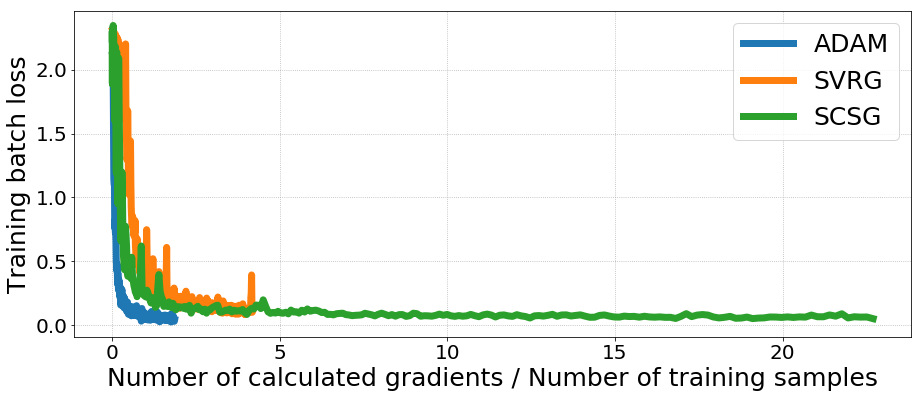

In [40]:
n = 55000
plt.figure(figsize=(15, 6))
plt.plot(np.array(adam_nb_grads) / n, adam_loss_history, label='ADAM', lw=7)
plt.plot(np.array(svrg_nb_grads) / n, svrg_loss_history, label='SVRG', lw=7)
# plt.plot(np.array(snvrg_nb_grads) / n, snvrg_loss_history, label='SNVRG', lw=7)
plt.plot(np.array(scsg_nb_grads) / n, scsg_loss_history, label='SCSG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of calculated gradients / Number of training samples', fontsize=25)
plt.ylabel('Training batch loss', fontsize=25)
plt.show()

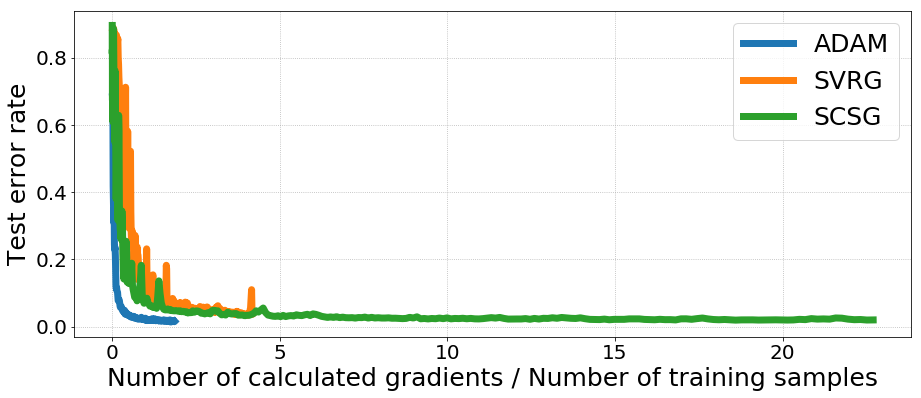

In [41]:
n = 55000
plt.figure(figsize=(15, 6))
plt.plot(np.array(adam_nb_grads) / n, adam_test_error_history, label='ADAM', lw=7)
plt.plot(np.array(svrg_nb_grads) / n, svrg_test_error_history, label='SVRG', lw=7)
# plt.plot(np.array(snvrg_nb_grads) / n, snvrg_test_error_history, label='SNVRG', lw=7)
plt.plot(np.array(scsg_nb_grads) / n, scsg_test_error_history, label='SCSG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of calculated gradients / Number of training samples', fontsize=25)
plt.ylabel('Test error rate', fontsize=25)
plt.show()

We can see that Adam ontains the best performance (both training batch loss and test error rate) with the smallest calculated gradients. Even though the other two can also obtain similar performance with enough steps, the number of calculated gradients is greater than that of Adam.

## Discussion and Conclusion

In this project, we implemented the SNVRG and SCSG algorithm and tested them on a convex problem (logistic regression with LASSO regularization) and a non-convex problem (MNIST image classification). We also compared their performance with Adam and SVRG algorithm.

According to our experiments, we found that Adam still obtains the best performance w.r.t. the training time and the final test error rate. For the other three algorithms, we found that 
- SVRG and SCSG can obtain similar performance within reasonable time, but with more calculated gradients.
- however, SNVRG is too time consuming and memory consuming. Even though it can obtain similar performance, it is not applicable in real applications.

We can also see that SVRG, SNVRG and SCSG are much more oscillating than Adam which is because in their inner iterations, they take a single gradient or on a small mini-batch. And the gradient on a single sample or on a small mini-batch should vary too much w.r.t. the real gradients.